In [2]:
!pip install tensorflow


In [6]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

#import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations

In [8]:
!pip install gradio

   ---------------------------------------- 0.0/54.3 MB ? eta -:--:--
   - -------------------------------------- 1.8/54.3 MB 8.4 MB/s eta 0:00:07
   -- ------------------------------------- 3.1/54.3 MB 7.4 MB/s eta 0:00:07
   --- ------------------------------------ 4.5/54.3 MB 7.1 MB/s eta 0:00:08
   ---- ----------------------------------- 5.8/54.3 MB 6.9 MB/s eta 0:00:08
   ----- ---------------------------------- 7.1/54.3 MB 6.7 MB/s eta 0:00:08
   ------ --------------------------------- 8.4/54.3 MB 6.6 MB/s eta 0:00:07
   ------- -------------------------------- 9.7/54.3 MB 6.5 MB/s eta 0:00:07
   -------- ------------------------------- 11.0/54.3 MB 6.6 MB/s eta 0:00:07
   --------- ------------------------------ 12.3/54.3 MB 6.5 MB/s eta 0:00:07
   ---------- ----------------------------- 13.6/54.3 MB 6.5 MB/s eta 0:00:07
   ----------- ---------------------------- 14.9/54.3 MB 6.5 MB/s eta 0:00:07
   ----------- ---------------------------- 16.0/54.3 MB 6.5 MB/s eta 0:00:06
 

In [10]:
import gradio as gr #for web interface. it i s library. to deploy and test ML models

In [20]:
#loading data
train_path=r'C:\Users\shrad\Downloads\E-Waste classification dataset\modified-dataset\train'
test_path=r'C:\Users\shrad\Downloads\E-Waste classification dataset\modified-dataset\test'
validate_path=r'C:\Users\shrad\Downloads\E-Waste classification dataset\modified-dataset\val'

In [22]:
#explore data
datatrain= tf.keras.utils.image_dataset_from_directory(train_path,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)
datatest= tf.keras.utils.image_dataset_from_directory(test_path, shuffle=True, image_size=(128,128),batch_size=32, validation_split=False)
dataval= tf.keras.utils.image_dataset_from_directory(validate_path, shuffle=True,image_size=(128,128), batch_size=32, validation_split=False)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [34]:
print(datatrain.class_names)
class_names=datatrain.class_names
print(len(datatrain.class_names))

['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']
10


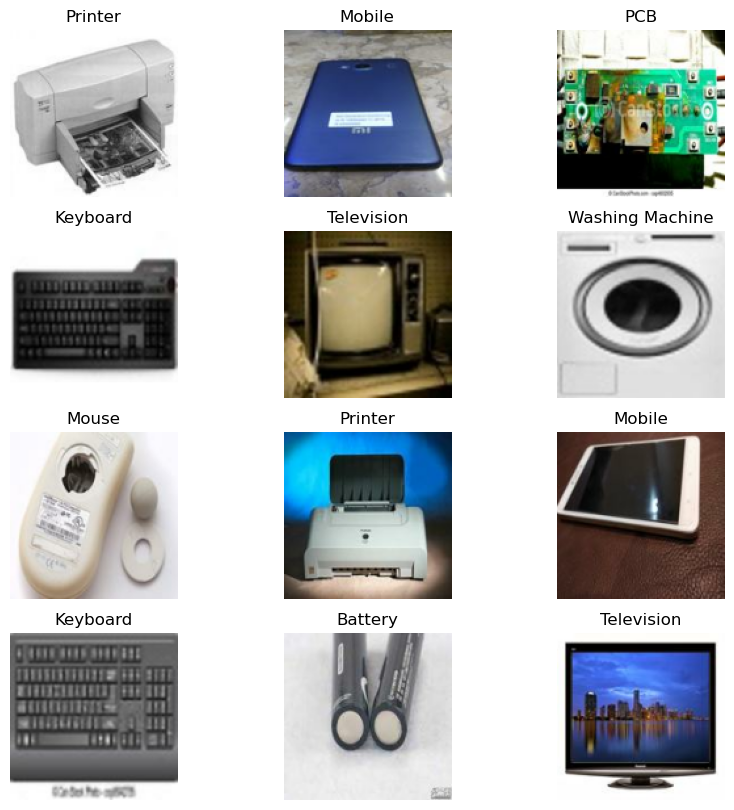

In [36]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

In [66]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

In [70]:
 # Prepare data for plotting
class_names = list(class_counts.keys())  # List of class names
counts = list(class_counts.values())     # Corresponding counts for each class

NameError: name 'class_counts' is not defined

In [86]:
#preprocessing the data
#as all the images are of same size resizing and rescaling is not required
data_augmentation = tf.keras.Sequential ([tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomRotation(0.1), tf.keras.layers.RandomZoom(0.1),])

# Load datasets from directories
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

validate_dataset = tf.keras.utils.image_dataset_from_directory(
    validate_path,
    image_size=(128, 128),
    batch_size=32,
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(128, 128),
    batch_size=32,
    shuffle=False
)
#normalize images
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    return preprocess_input(image), label

# Apply preprocessing
train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
validate_dataset = validate_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [90]:
#step3 model selection
#choosing effcientnetv2b0 as base model instead of direcct cnn
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False
